In [20]:
from IPython.display import Image
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Lecture Material: 

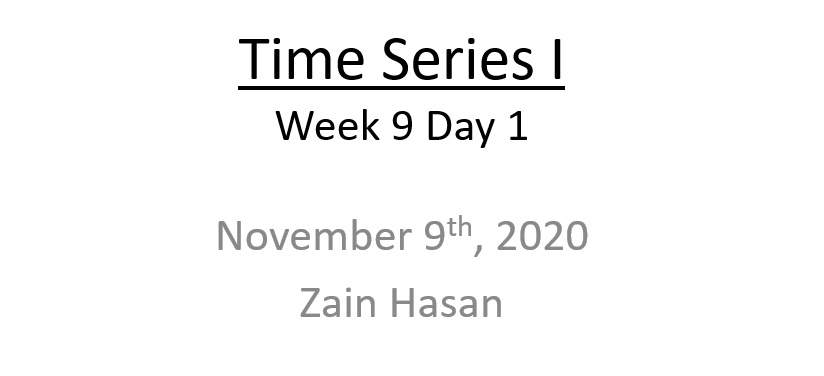

In [2]:
Image("1.PNG")

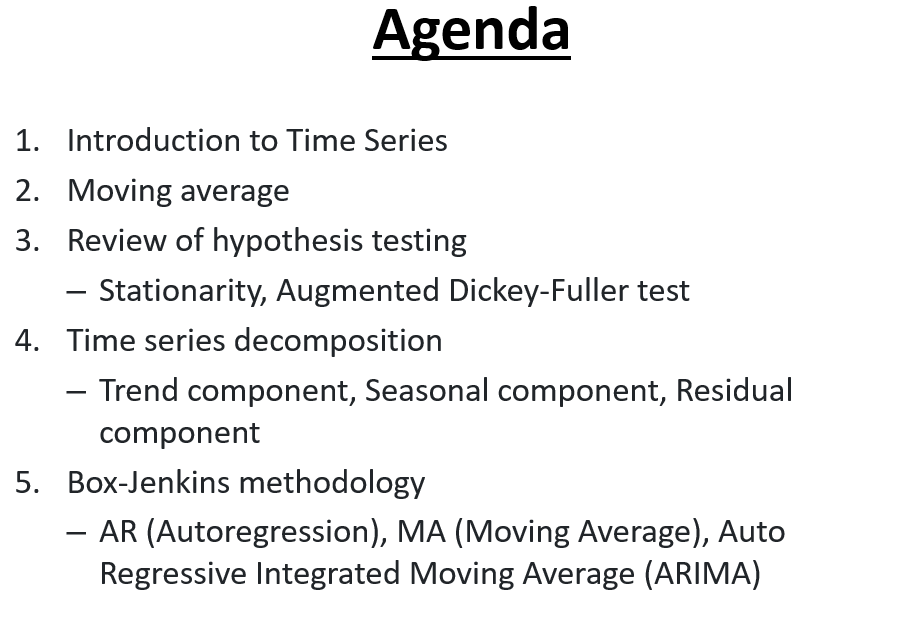

In [4]:
Image("2.PNG")

## Time Series

* A series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time.

* Think of data sets that take observations periodically over a period of time:
* Weather Forecasting
* EEG Signals
* Youtube Ad Analysis
* Spending Habits


In [8]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], 
                  parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], 
                       parse_dates=['Time'])

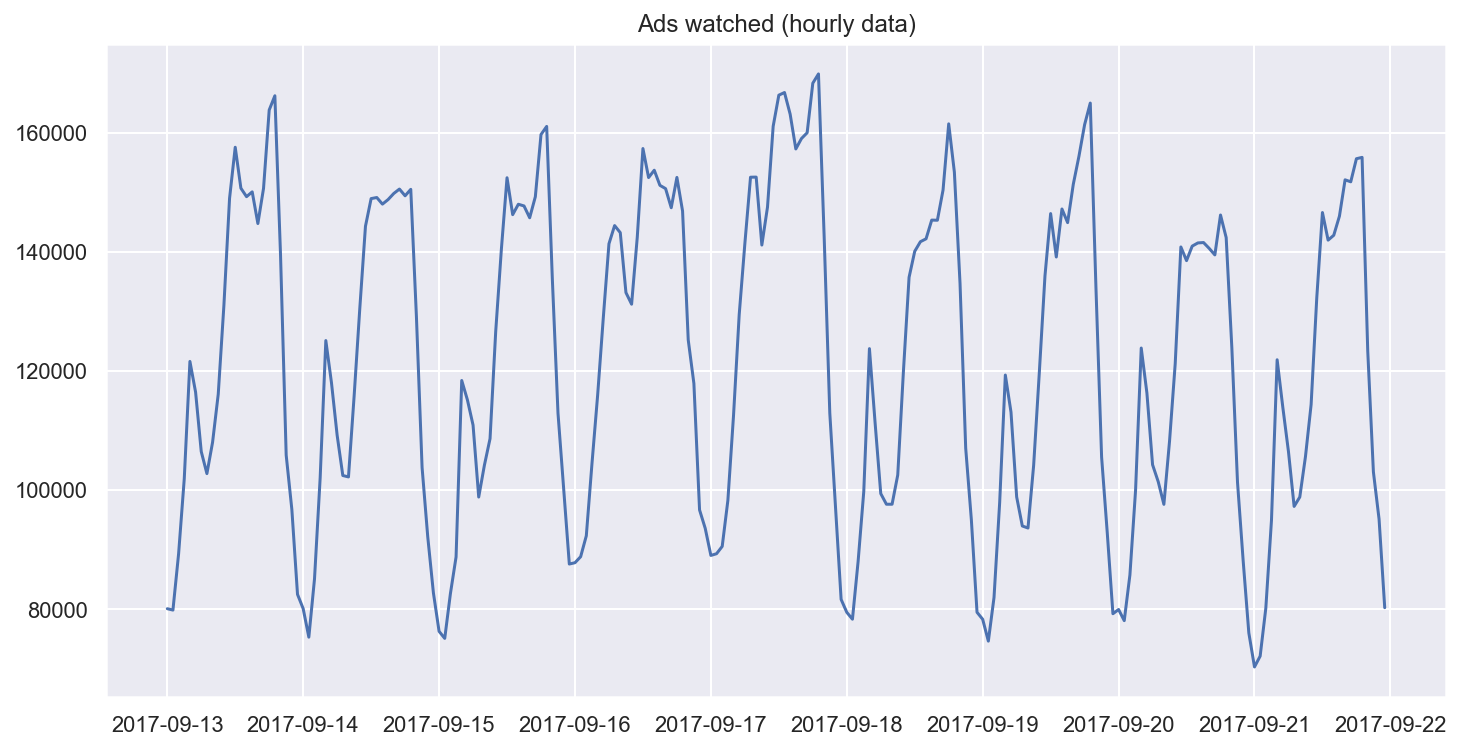

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

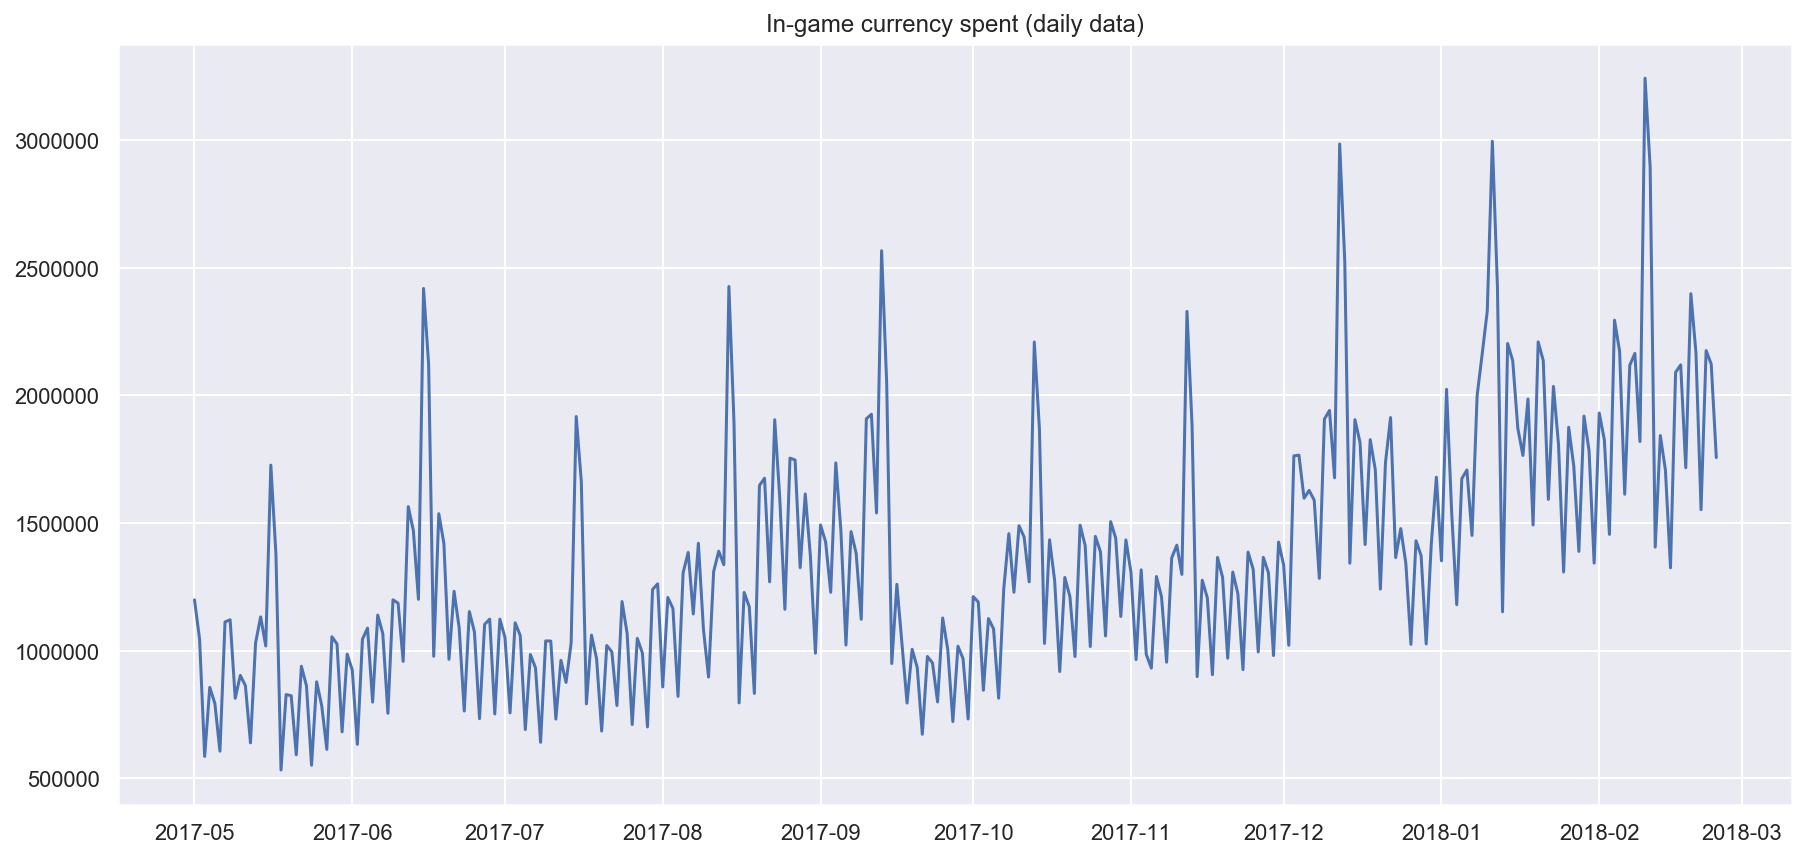

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

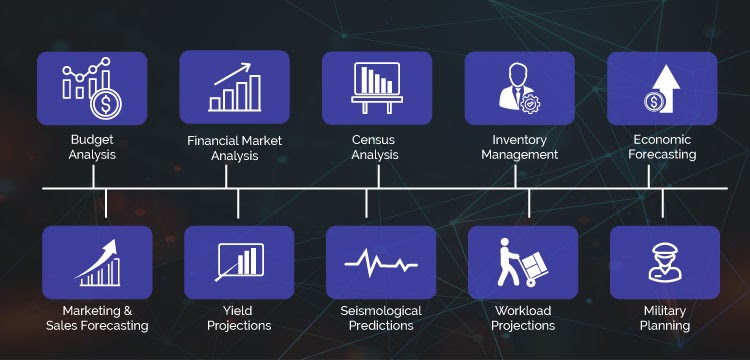

In [5]:
Image("application-of-time-series.jpg")

## Prediction/Forecasting in Time Series

* Involves using a model that is given previously observed values with the task of predicting future values.

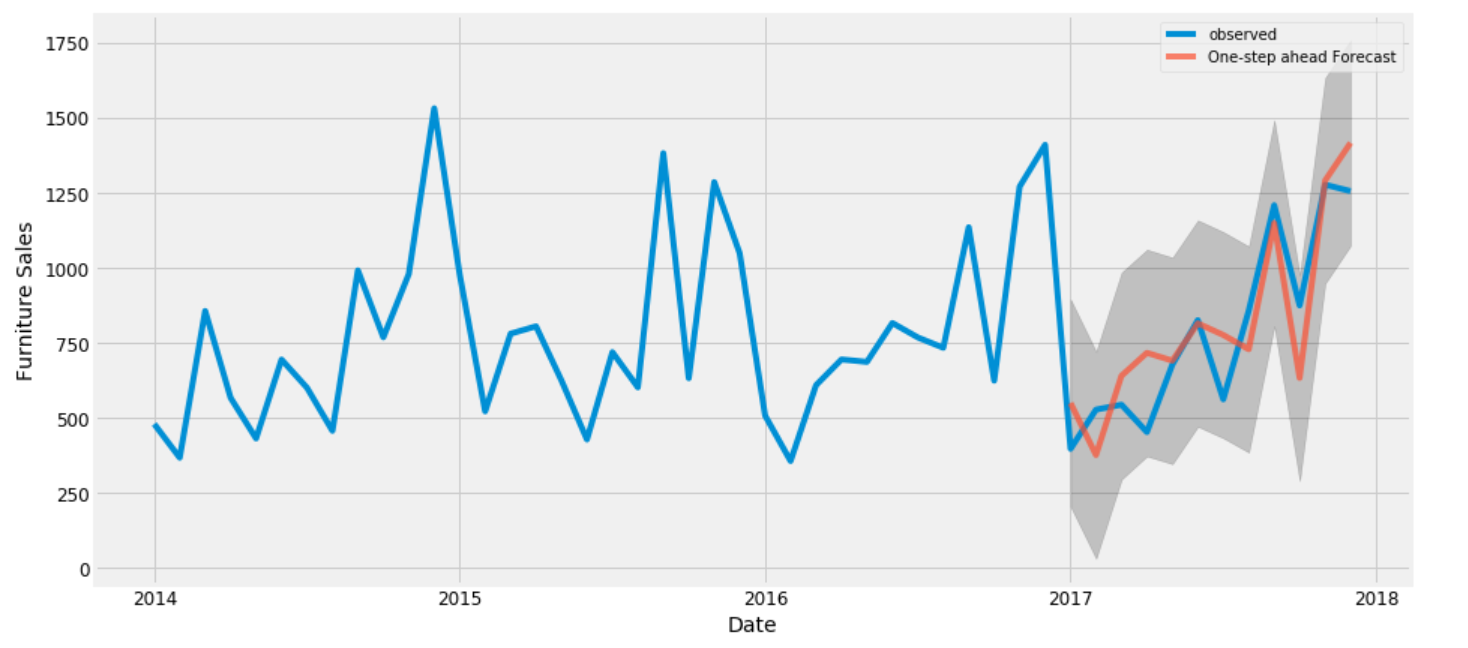

In [6]:
Image("prediction.png")

## Time Series Prediction Metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---


## Preprocessing Time Series Data: Moving Average

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [11]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

Unfortunately, we cannot make predictions far in the future - in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [17]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Let's smooth by the previous 4 hours.

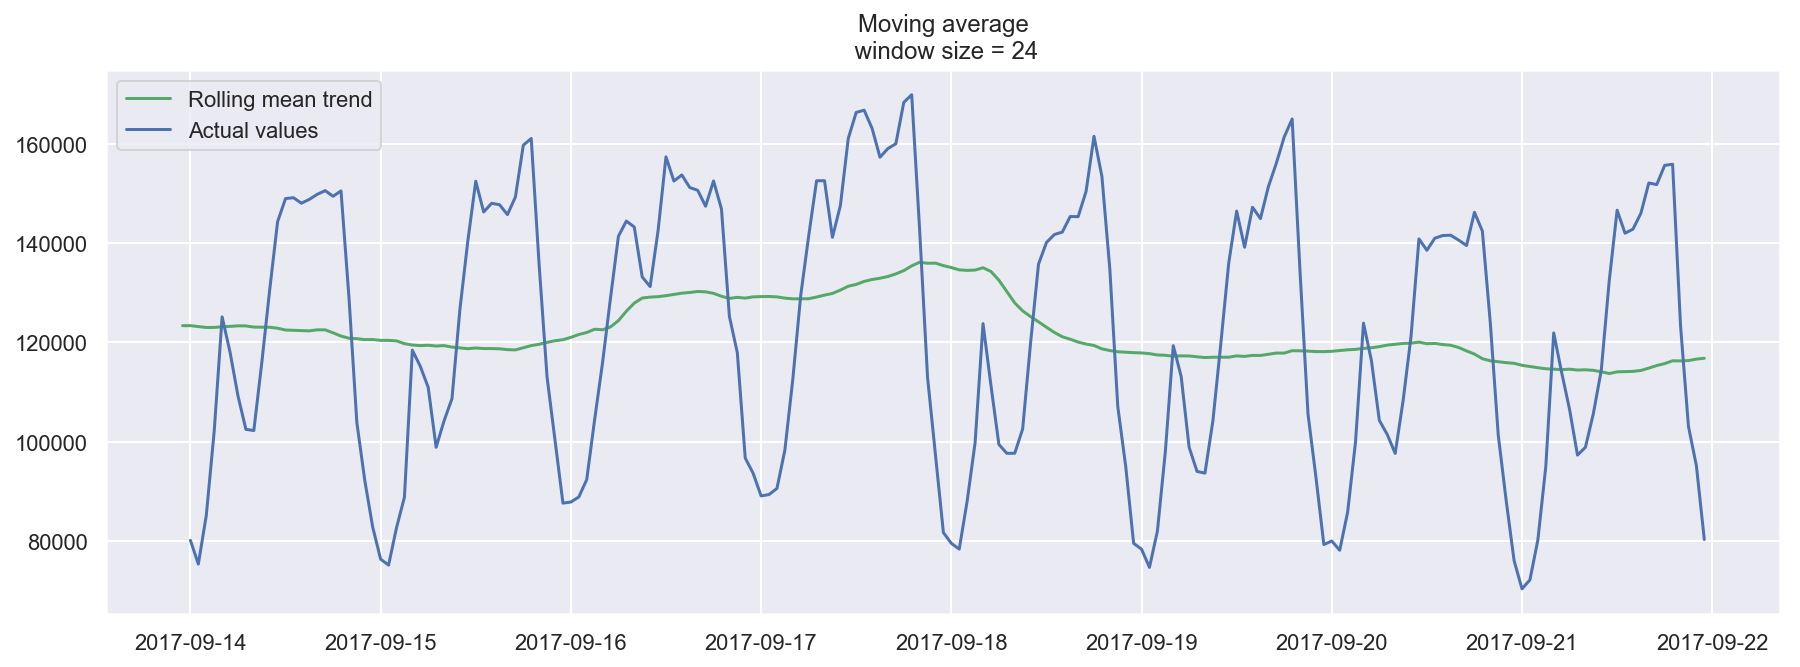

In [52]:
plotMovingAverage(ads, 24) 

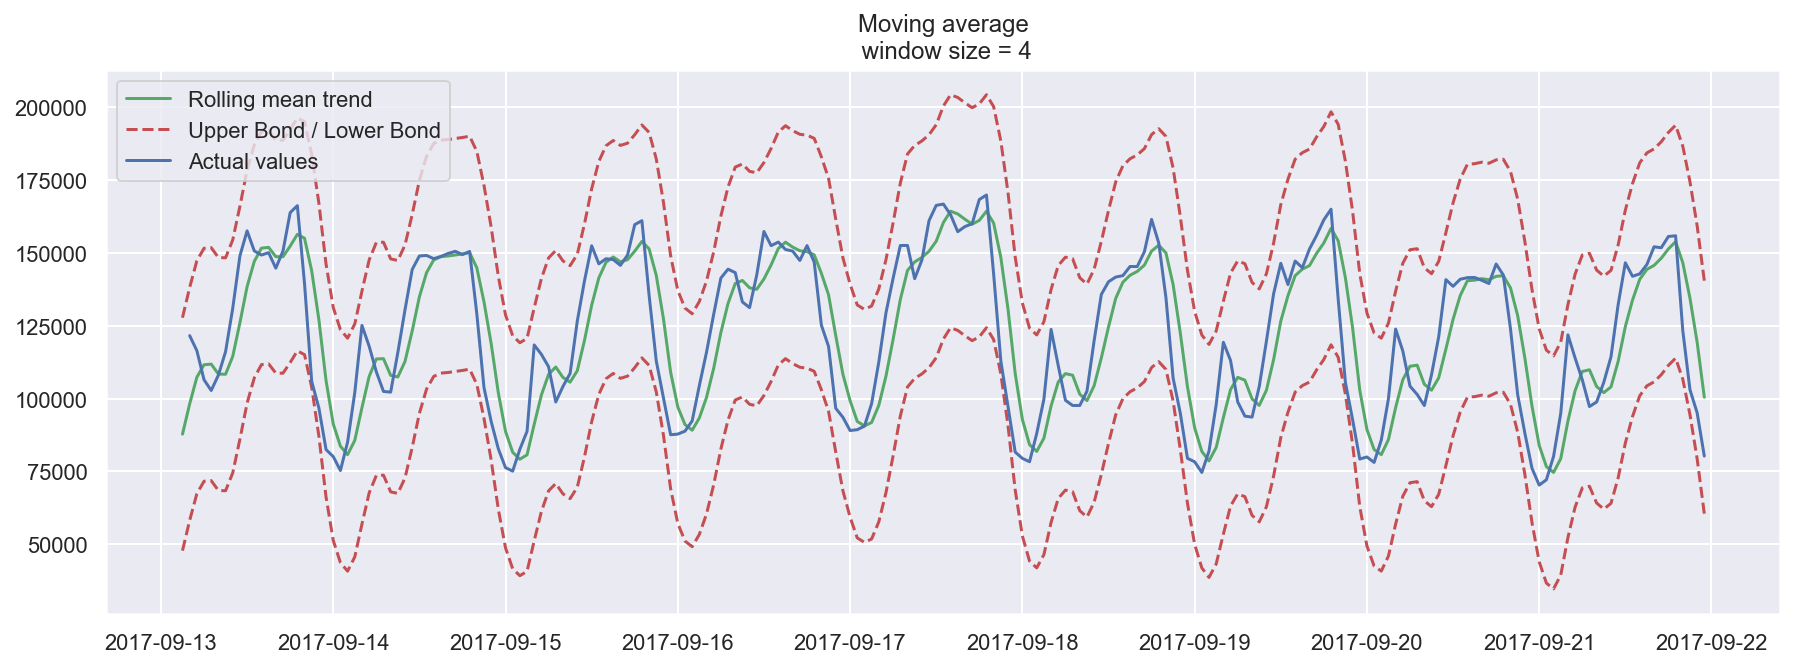

In [21]:
plotMovingAverage(ads, 4, plot_intervals=True)

### There are more exotic varieties of these types of preprocessing: exponential smoothing, double exponential smoothing, triple exponential smooting. 

## Stationarity

Before we start modeling, we should mention such an important property of time series: [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations.

- The red graph below is not stationary because the mean increases over time.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- The red graph below is not stationary because the variance increases over time.

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

## So why is stationarity so important? 

Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

## The Augmented Dickey-Fuller Test

* ADF - tests the null hypothesis that non-stationarity is present in a time series sample. The alternative hypothesis stationarity or trend-stationarity. 


* Intuition: The intuition behind the test is that if the series is characterised by a non-stationary process then the lagged level of the series (${\displaystyle y_{t-1}}$) will provide no relevant information in predicting the change in ${\displaystyle y_{t}}$ besides the one obtained in the lagged changes (${\displaystyle \Delta y_{t-k}}$). In this case the null hypothesis is not rejected. In contrast, if the null hypothesis is rejected, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected.

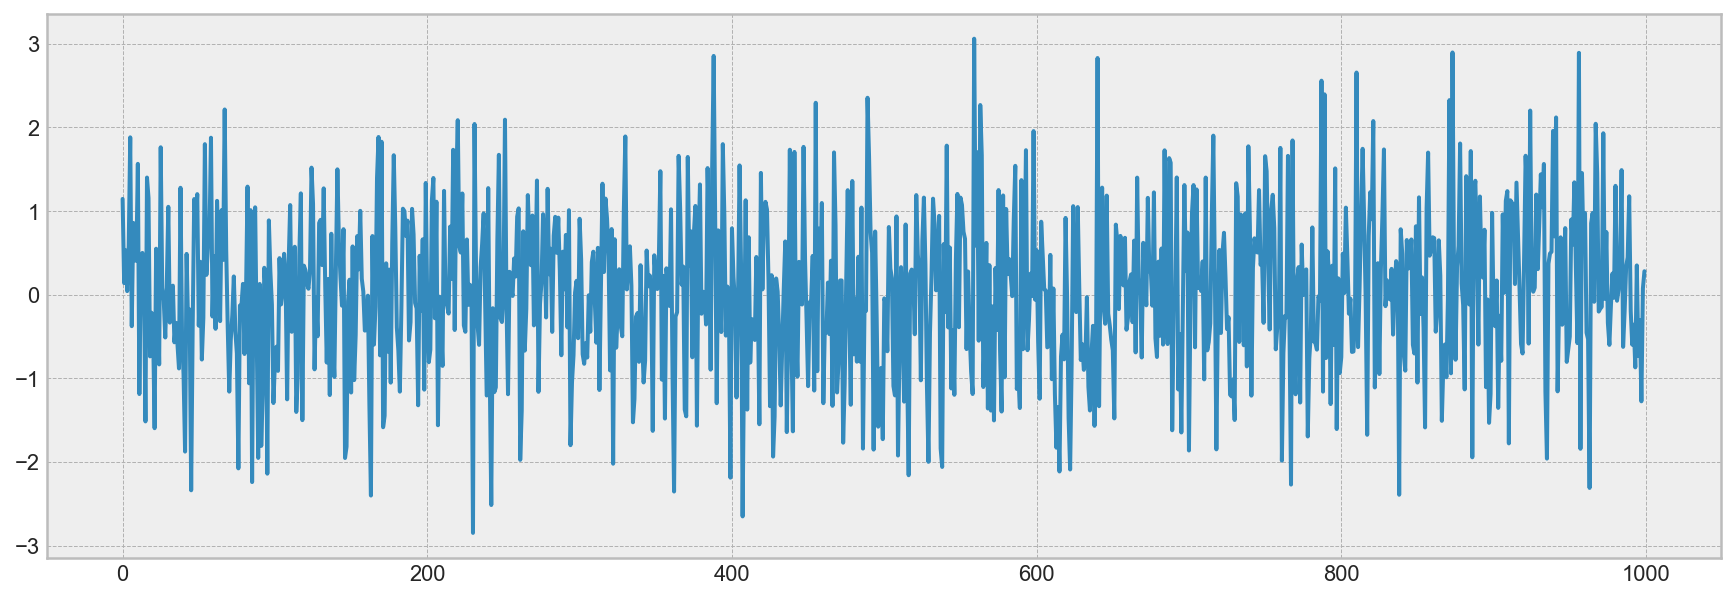

In [35]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

The process generated by the standard normal distribution is stationary and oscillates around 0 with deviation of 1. Now, based on this process, we will generate a new one where each subsequent value will depend on the previous one: $x_t = \rho x_{t-1} + w_t$ 

Here is the code to render the plots.

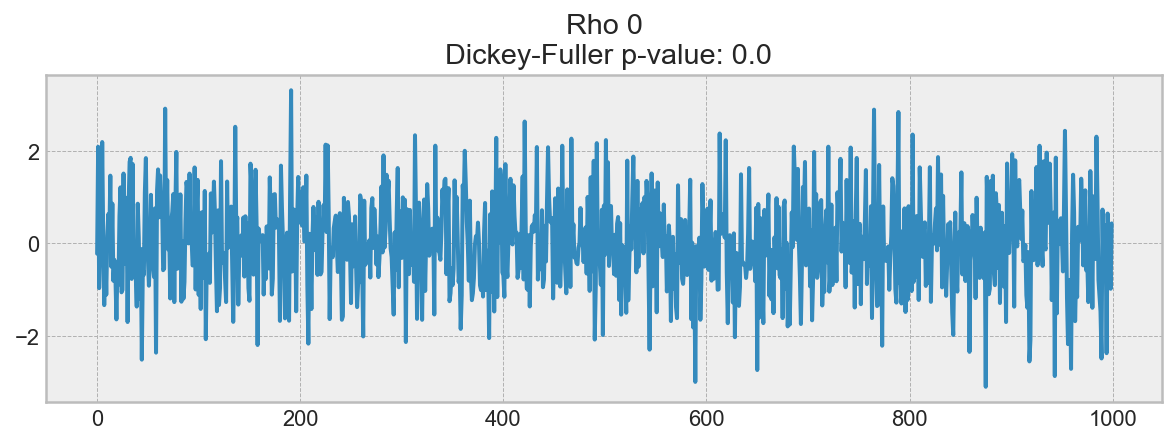

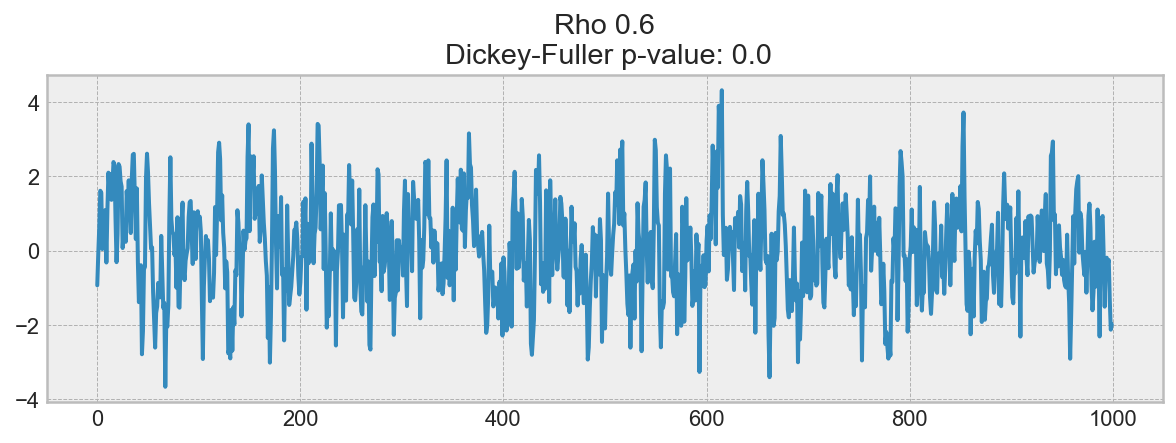

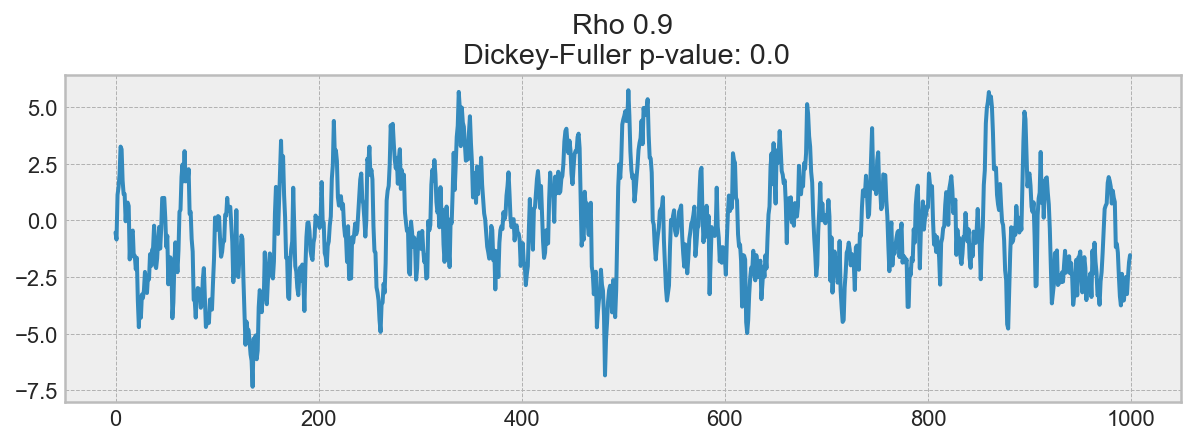

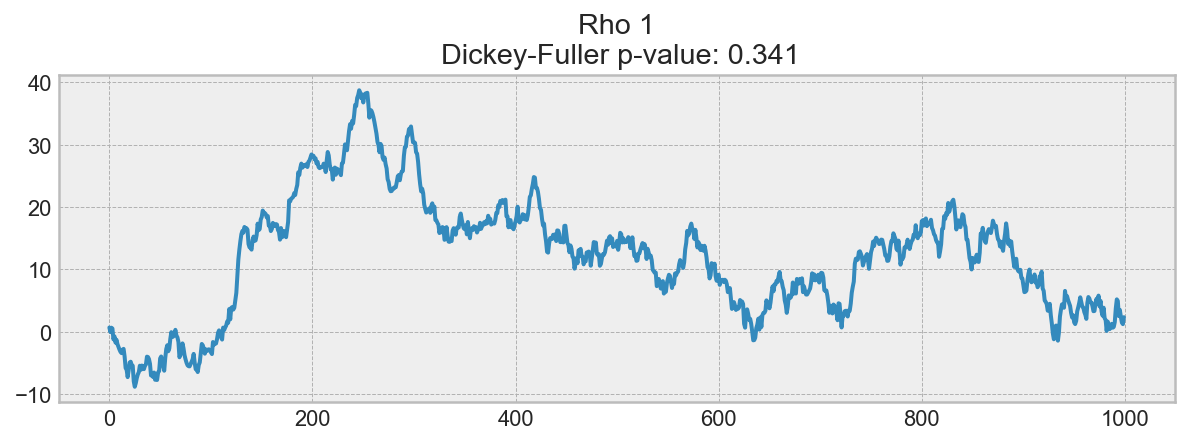

In [36]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Augmented Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

On the first plot, you can see the same stationary white noise as before. On the second plot with $\rho$ increased to 0.6, wider cycles appeared, but it still appears stationary overall. The third plot deviates even more from the 0 mean but still oscillates about the mean. Finally, with $\rho=1$, we have a random walk process i.e. a non-stationary time series.

This happens because, after reaching the critical value, the series $x_t = \rho x_{t-1} + e_t$ does not return to its mean value. If we subtract $x_{t-1}$ from both sides, we will get $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, where the expression on the left is referred to as the first difference. If $\rho=1$, then the first difference gives us stationary white noise $e_t$. 

This is the main idea behind the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) for stationarity of time series (testing the presence of a unit root). If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1. The null hypothesis of the test is that the time series is non-stationary, which was rejected on the first three plots and finally accepted on the last one. We have to say that the first difference is not always enough to get a stationary series as the process might be integrated of order d, d > 1 (and have multiple unit roots). In such cases, the augmented Dickey-Fuller test is used, which checks multiple lags at once.

## Q: How do we fight non-stationarity? A: Time-series Decomposition

Lets define the components of a time series as follows:

- **Level**: The average value in the series. - Mean
- **Trend**: The increasing or decreasing value in the series.
- **Seasonality/Cyclicality**: The repeating short-term cycle in the series.
- **Noise**: The random variation in the series.

Additive Time Series: y(t) = Level + Trend + Seasonality + Noise -> changes by same ammount over time, linear trend

Multiplicative Time Series: y(t) = Level * Trend * Seasonality * Noise -> changes increase of decrease over time, non-linear curved trend

Time series Decomposition is the process of decoupling each of these components.

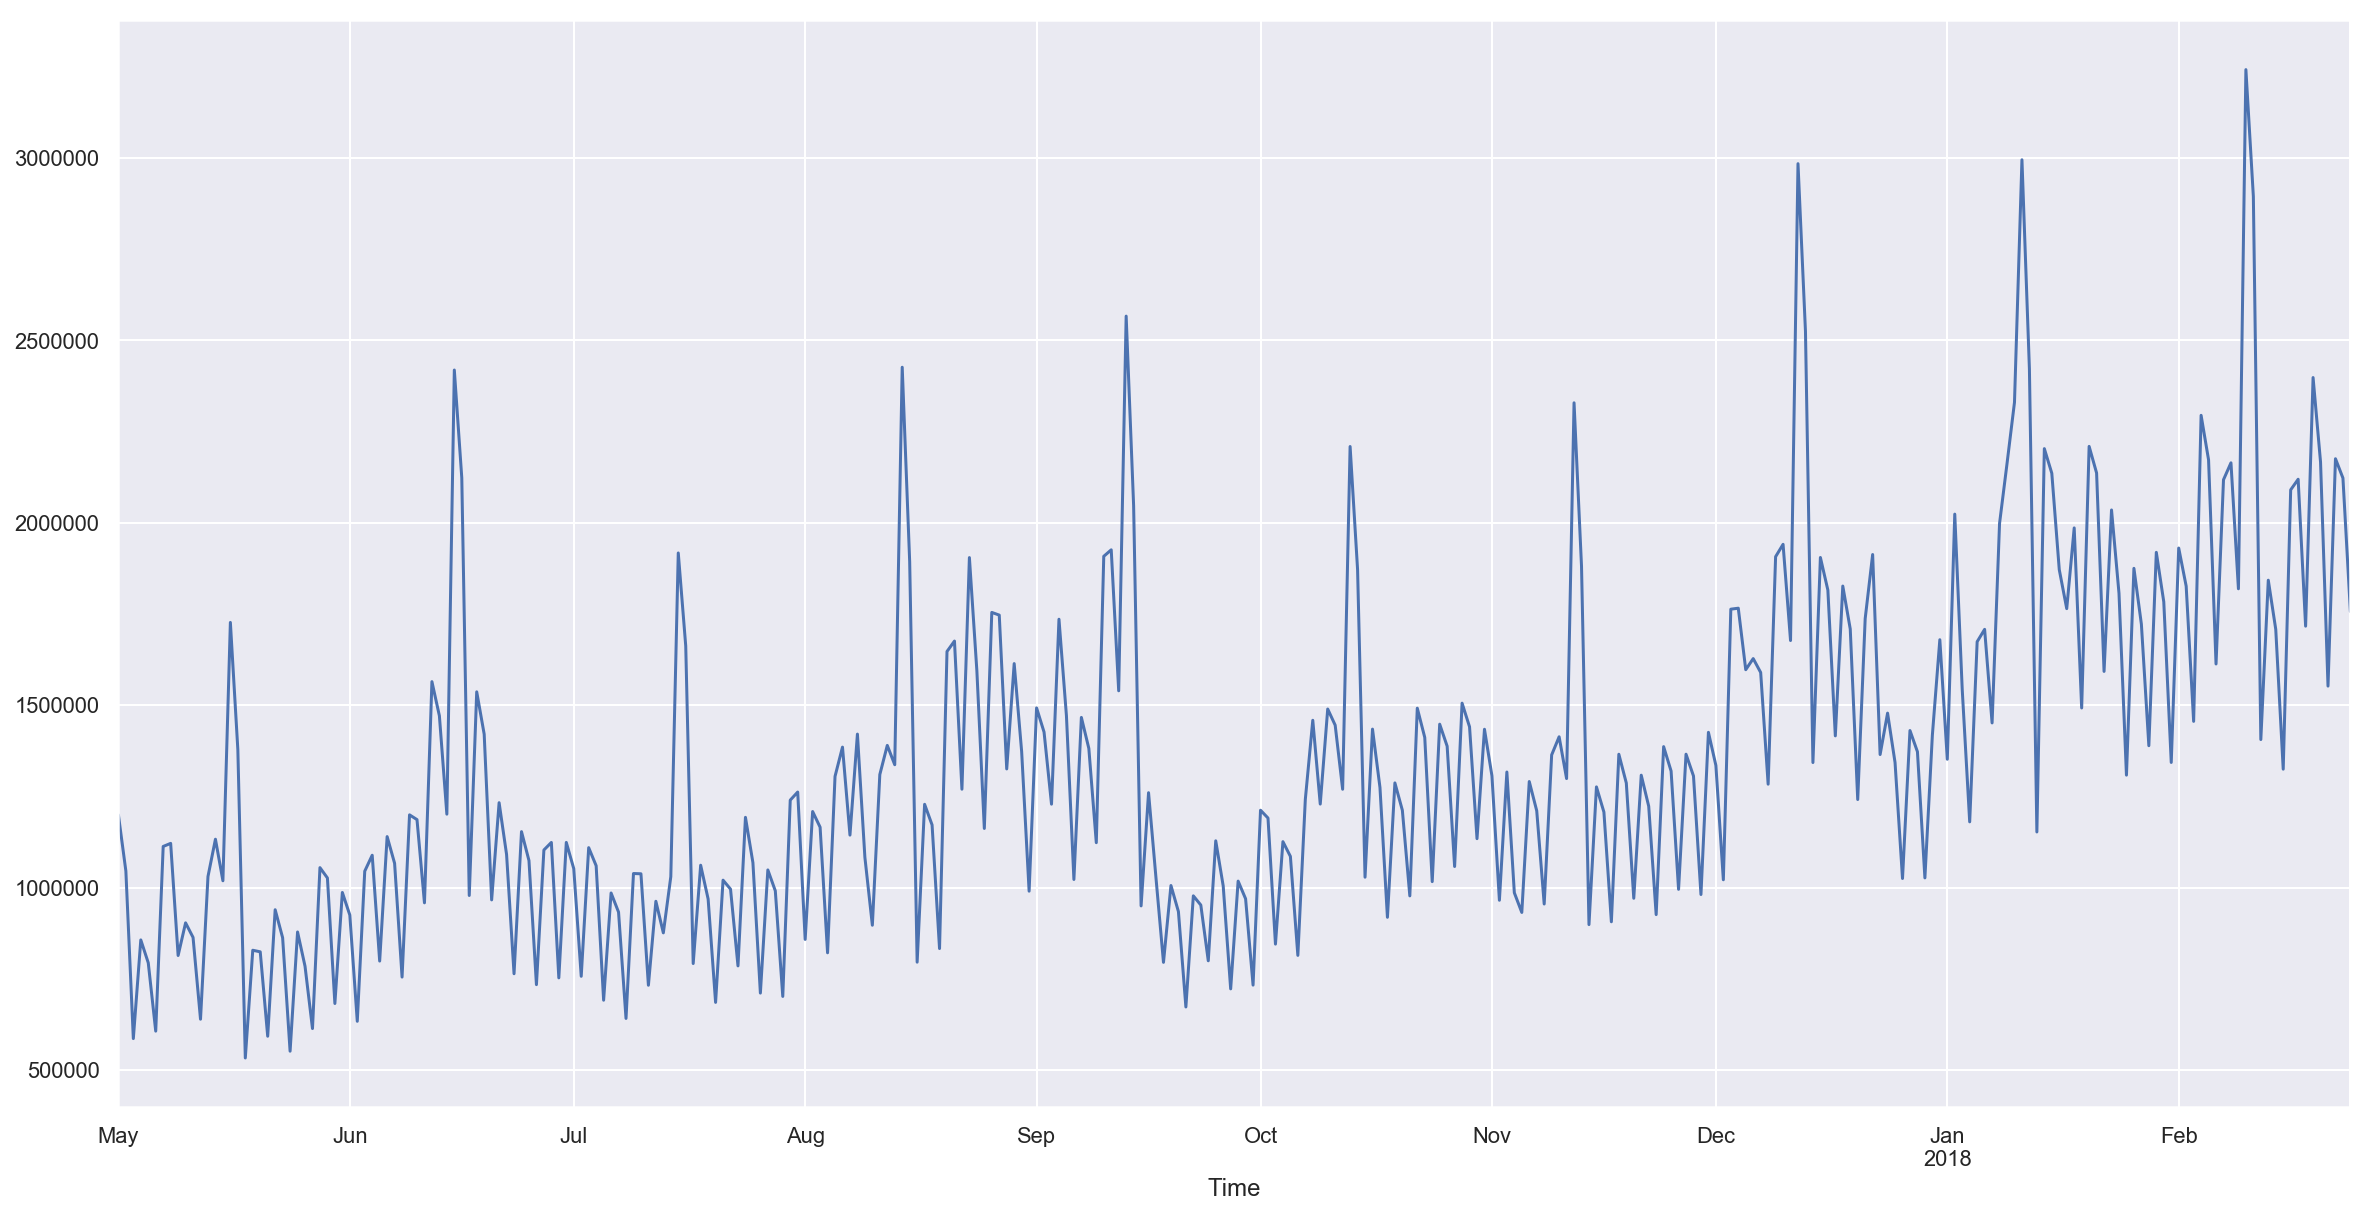

In [34]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (20,10)
series = currency.GEMS_GEMS_SPENT
series.plot()
plt.show()

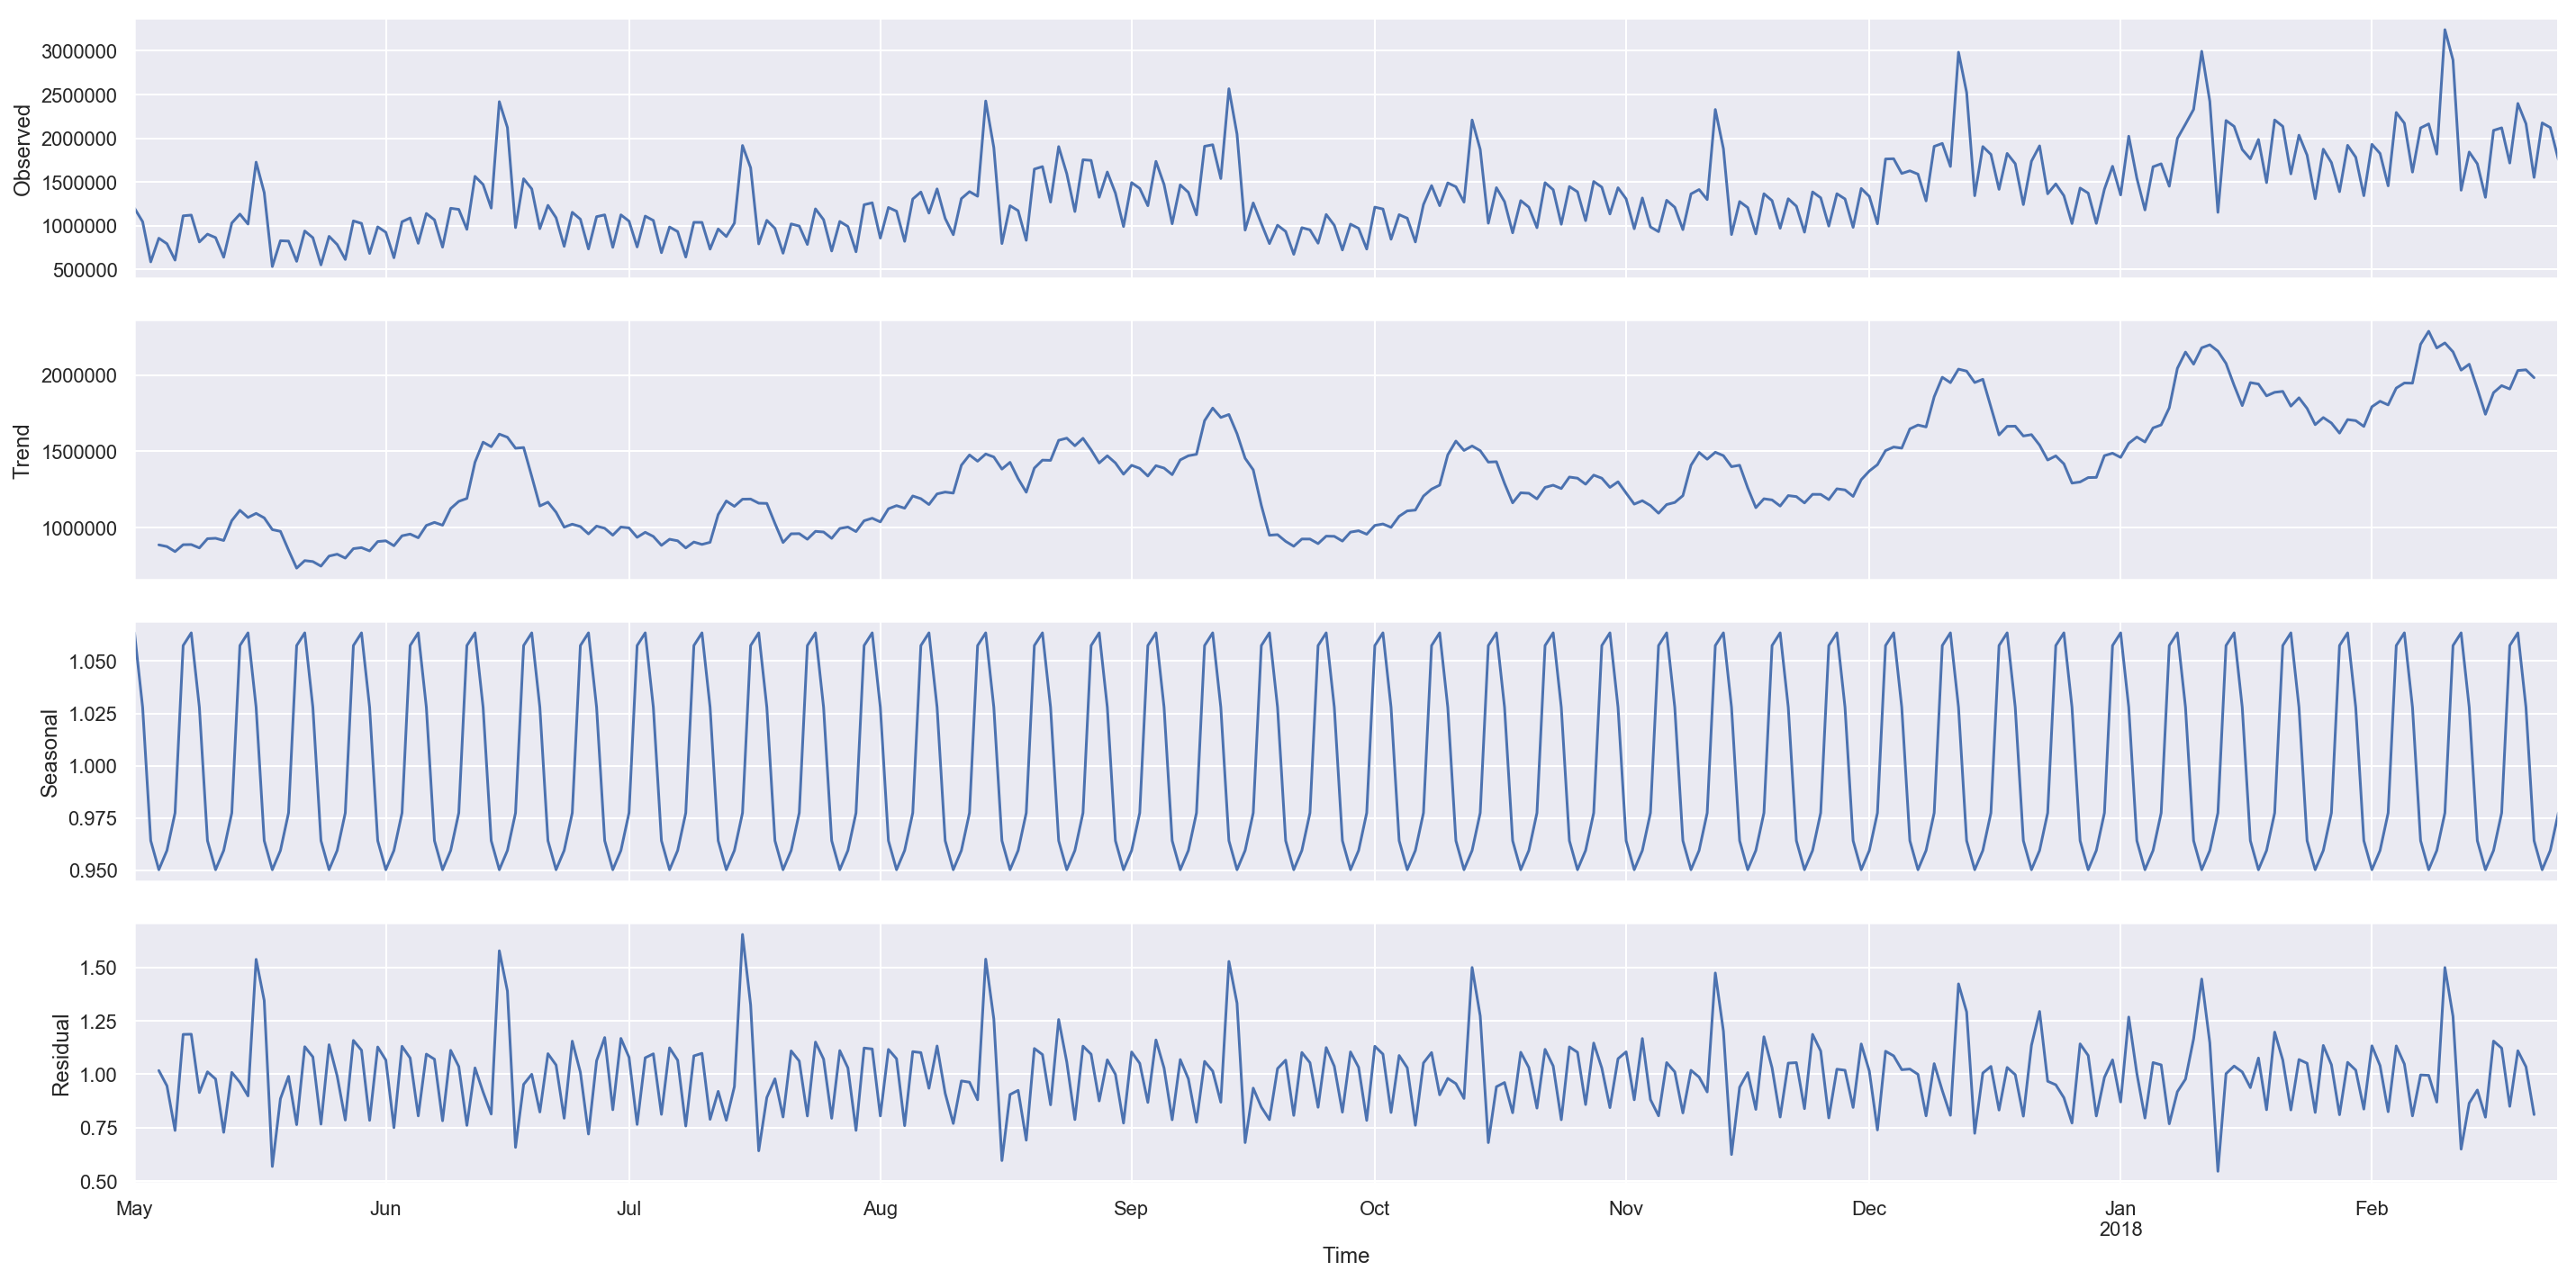

In [35]:
series = currency.GEMS_GEMS_SPENT
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show()

## Decomposition using Autocorrelation(ACF) and Partial Autocorrelation(PACF)

* **Autocorrelation Function (ACF)**. The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
* **Partial Autocorrelation Function (PACF)**. The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.

In [36]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

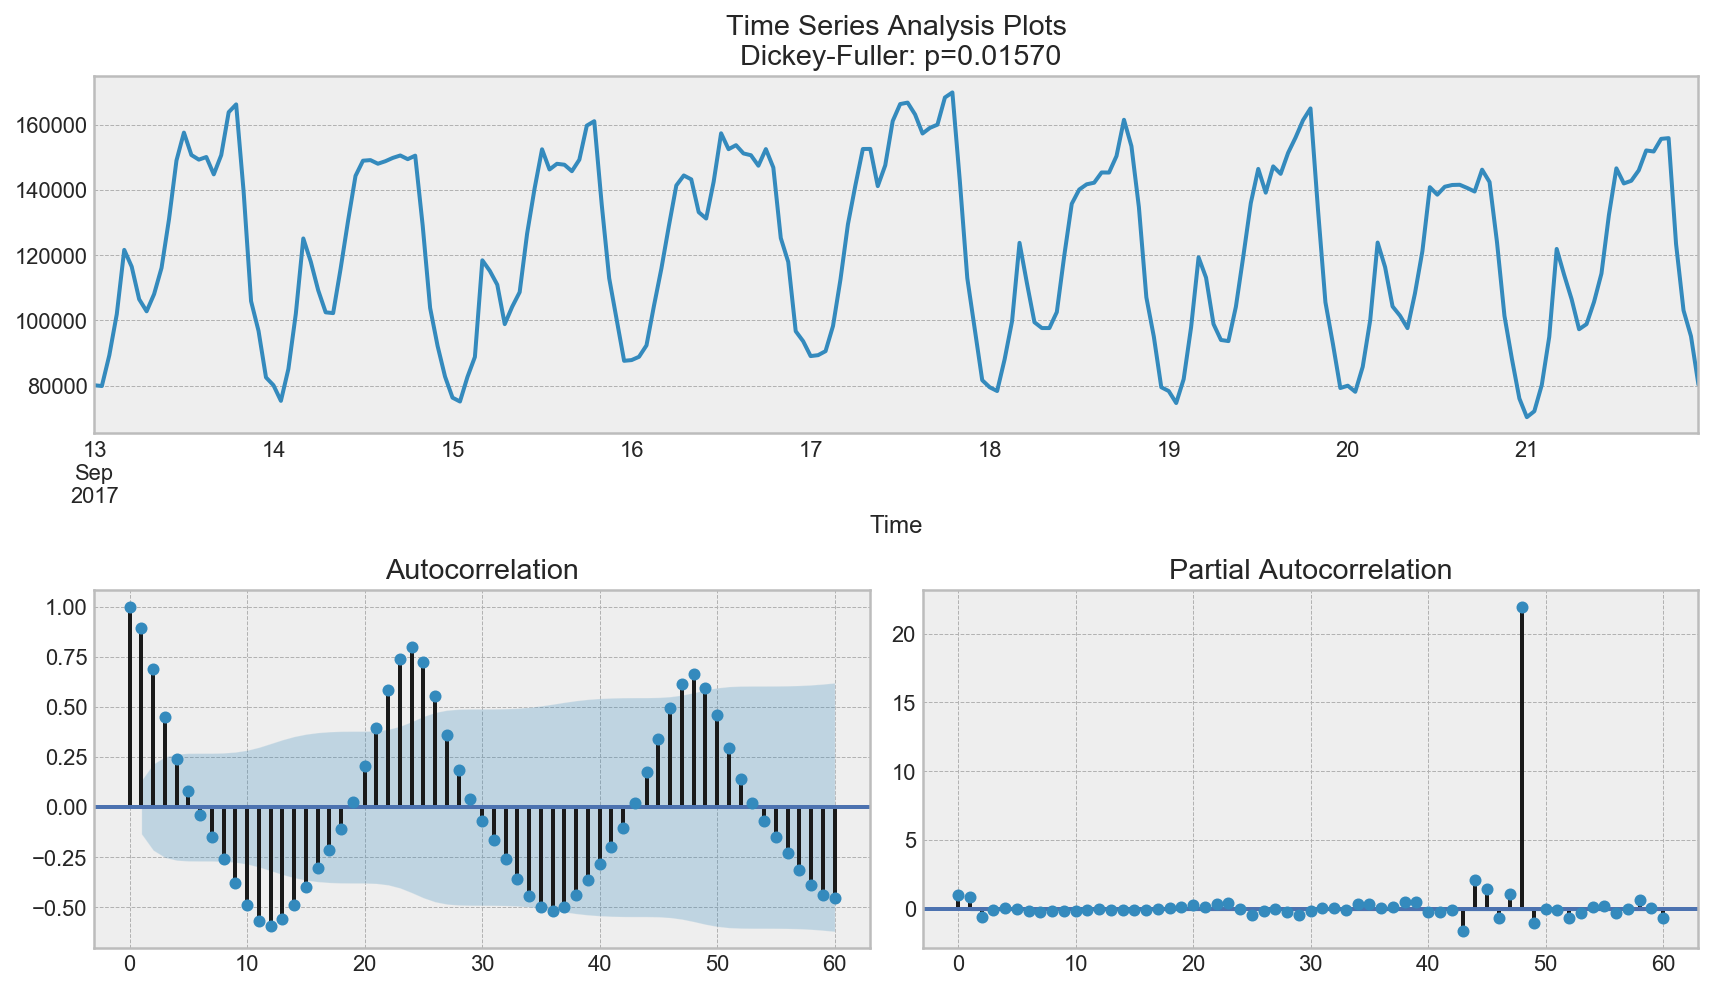

In [41]:
tsplot(ads.Ads, lags=60)

_this outlier on partial autocorrelation plot looks like a statsmodels bug, partial autocorrelation shall be <= 1 like any correlation._

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. Actually, we can see this on the plot itself – we do not have a visible trend, so the mean is constant and the variance is pretty much stable. The only thing left is seasonality, which we have to deal with prior to modeling. To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself with a lag that equals the seasonal period.

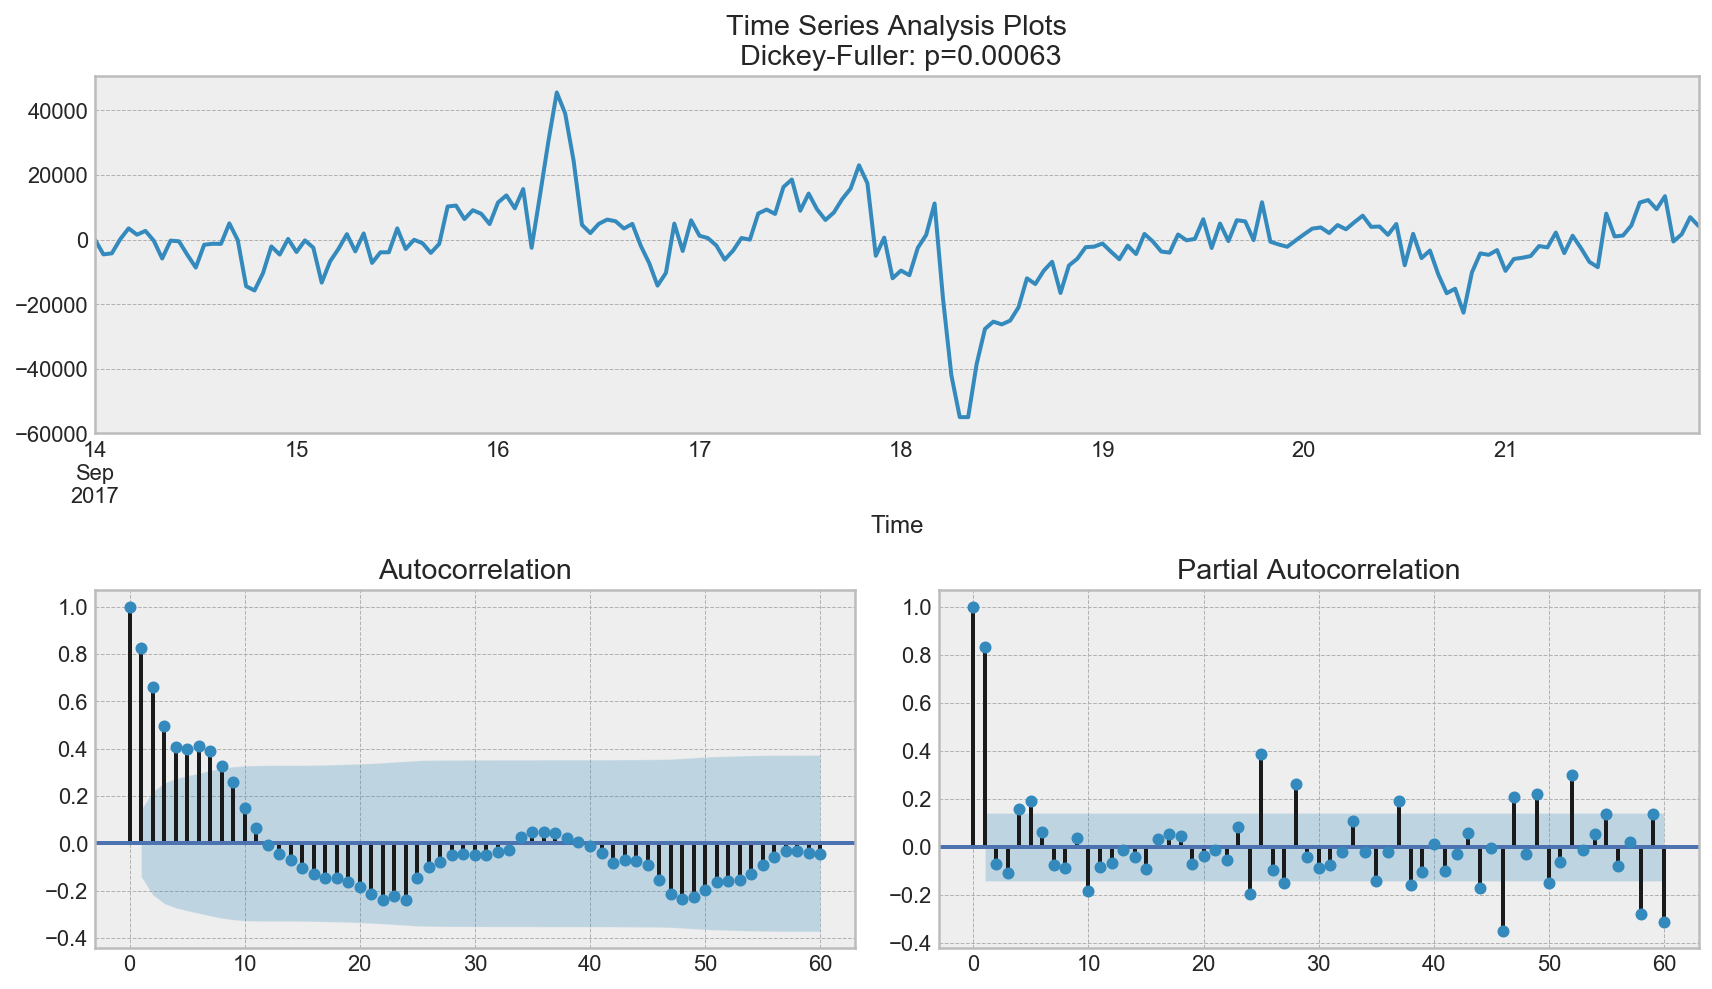

In [42]:
#Remove seasonality

ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

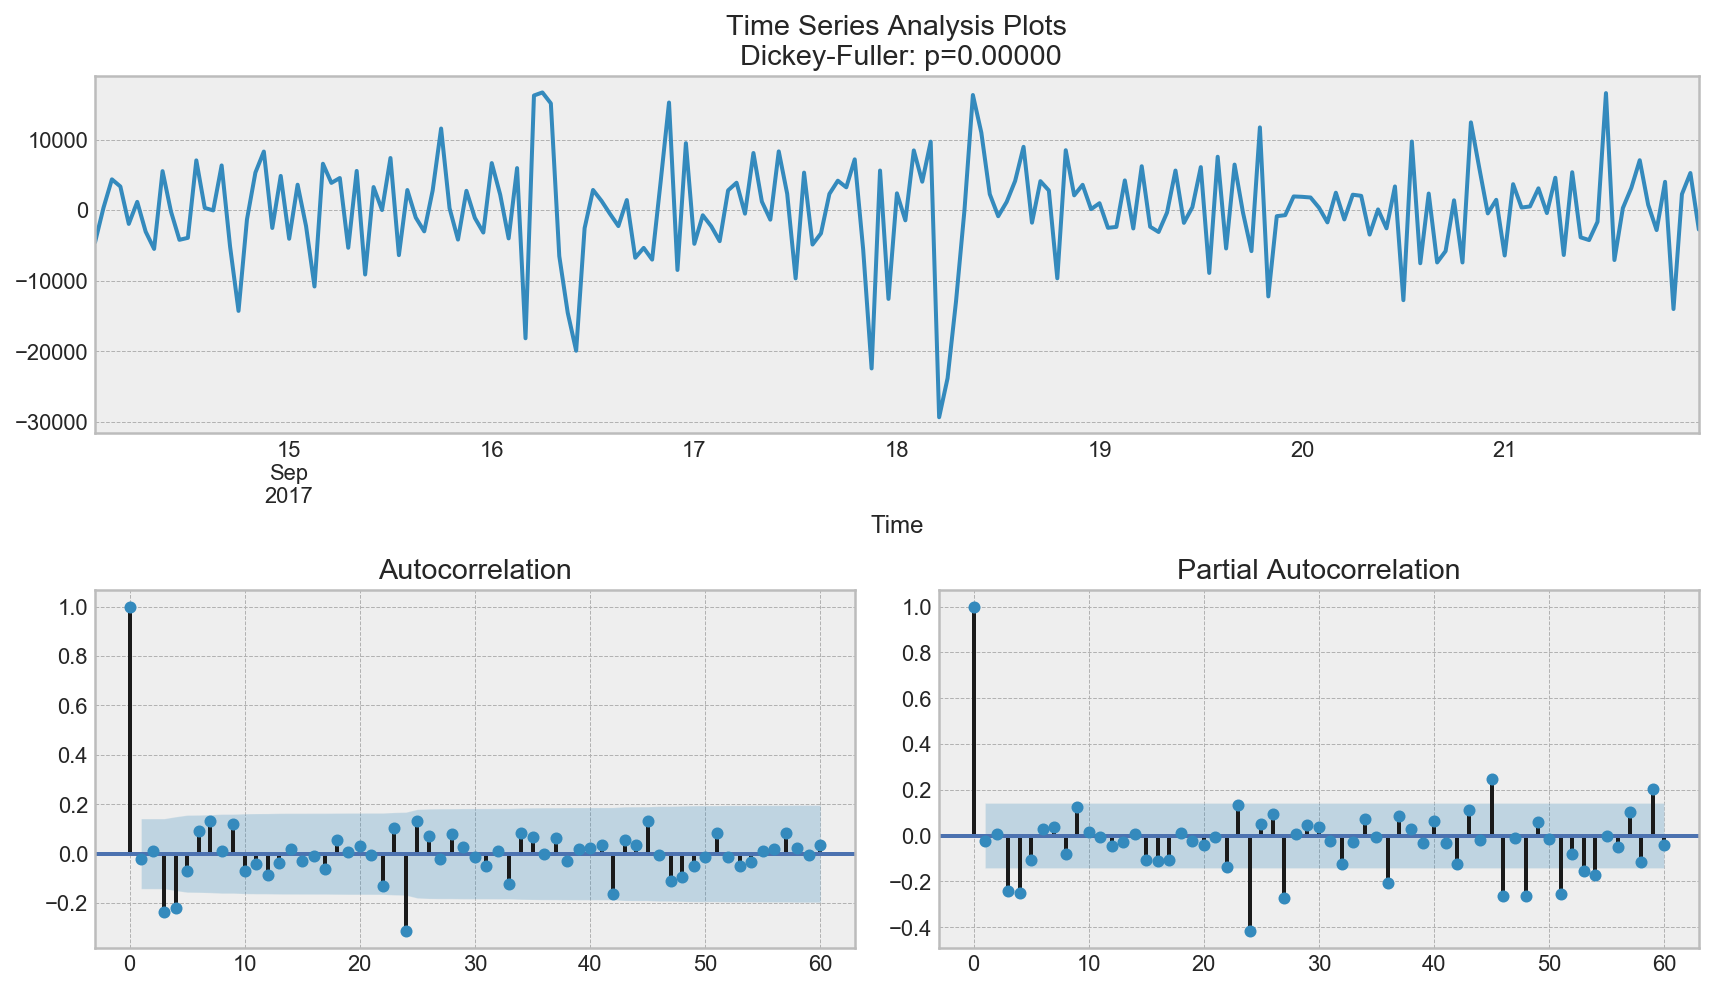

In [43]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!

## Lets get back to Forecasting/Predicting Time Series

## ARIMA (Auto Regressive Integrated Moving Average)

We will explain this model by building up letter by letter. $ARIMA(p, d, q)(P, D, Q)$:

- $AR(p)$ - autoregression model - A model that uses the dependent relationship between an observation and some number of lagged observations. i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as $p$. To determine the initial $p$, you need to look at the PACF plot and find the biggest significant lag after which **most** other lags become insignificant.
- $MA(q)$ - moving average model - A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as $q$. The initial value can be found on the ACF plot with the same logic as before. 

Let's combine our first 4 letters:

$AR(p) + MA(q) = ARMA(p, q)$

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

- $I(d)$ - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences. 

Adding this letter to the four gives us the $ARIMA$ model which can handle non-stationary data with the help of nonseasonal differences.

With this, we have three parameters: $(P, D, Q)$

- $P$ - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial $P$ should be 2.

- $Q$ - similar logic using the ACF plot instead.

- $D$ - The number of times that the raw observations are differenced, also called the degree of differencing.

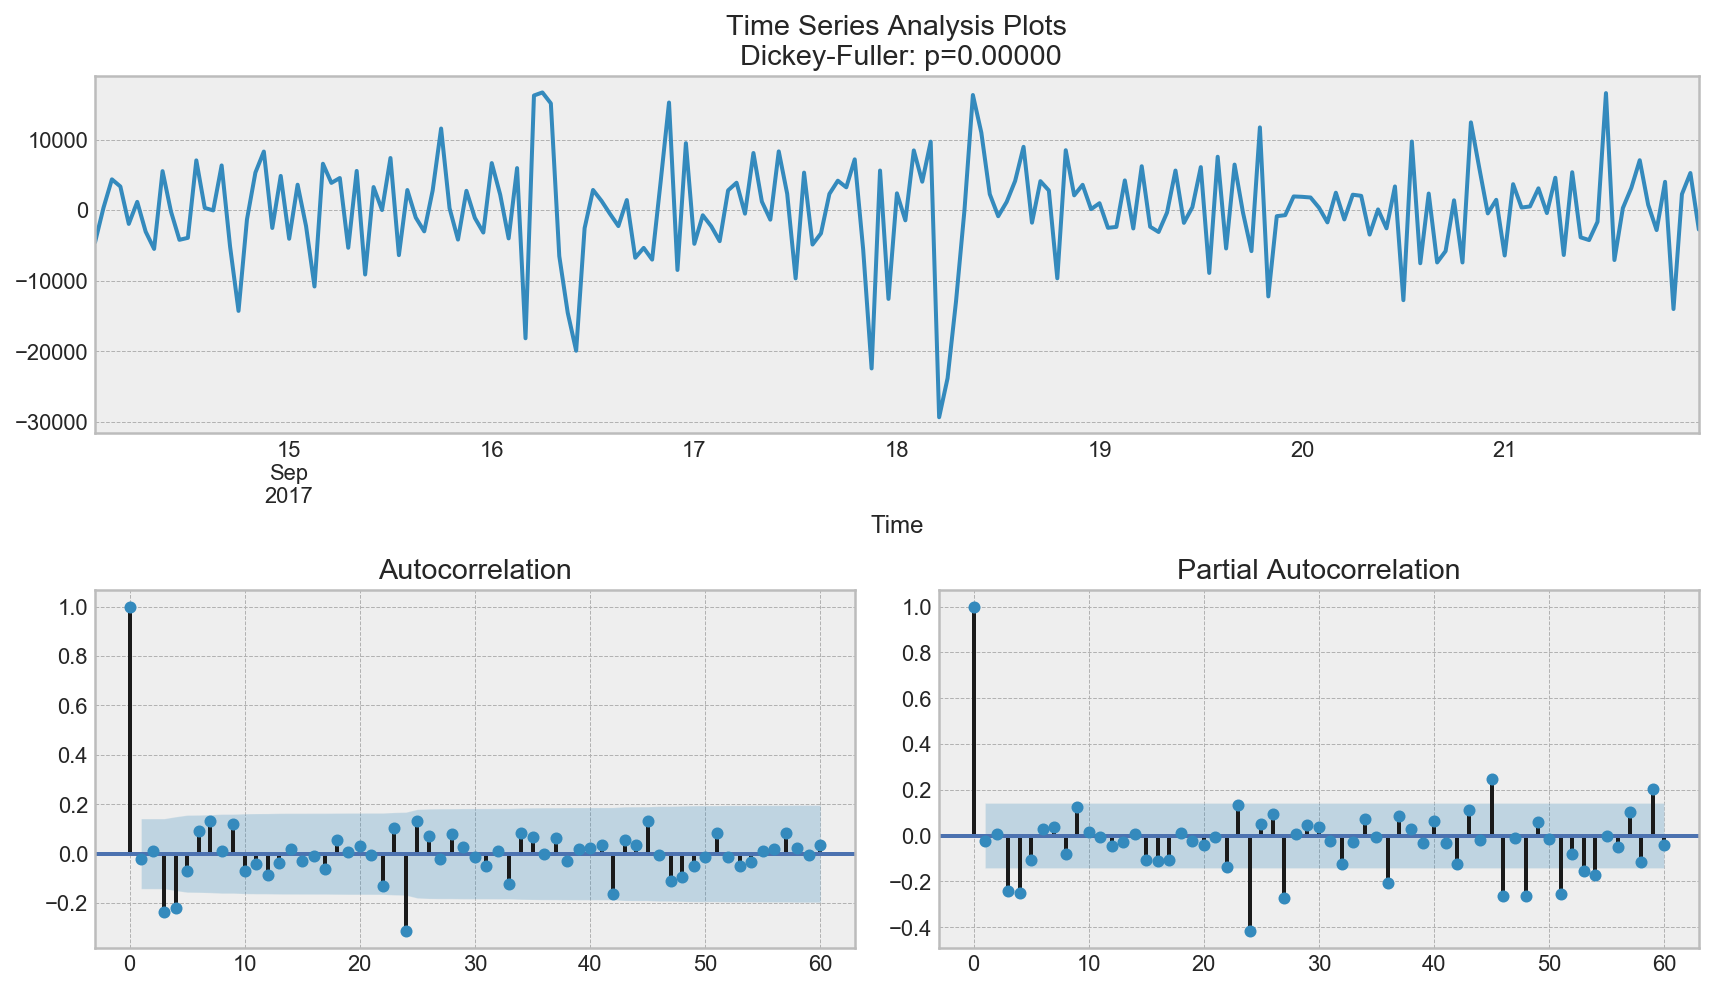

In [44]:
tsplot(ads_diff[24+1:], lags=60)

- $p$ is most probably 3 since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 3 as well as seen on the ACF
- $P$ might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- $D$ again equals 1 because we performed first differences
- $Q$ is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

### Keep in mind that we can also grid search over these parameters aswell

## Lets train the ARIMA Model

In [ ]:
# set the parameters
p, q, d, P, Q, D = (4,4,1,2,1,1)
s = 24 # season length is still 24 hours

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

Let's inspect the residuals of the model.

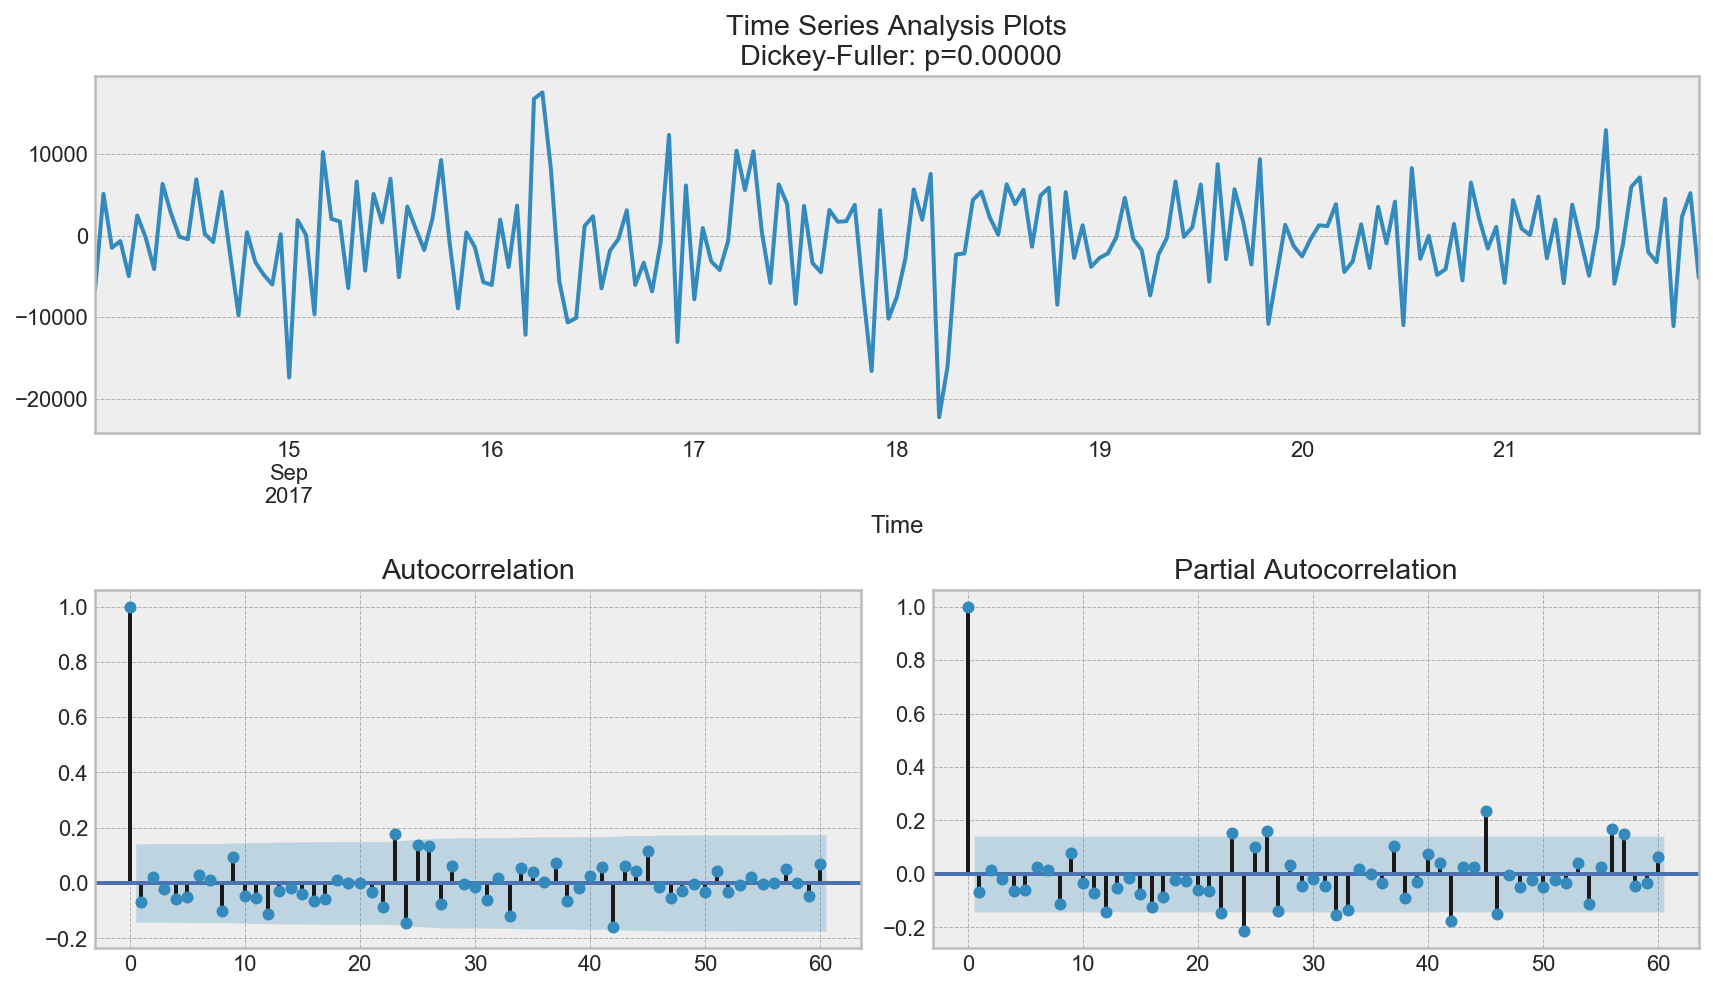

In [47]:
tsplot(best_model.resid[24+1:], lags=60)

It is clear that the residuals are stationary, and there are no apparent autocorrelations. Let's make predictions using our model.

In [48]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

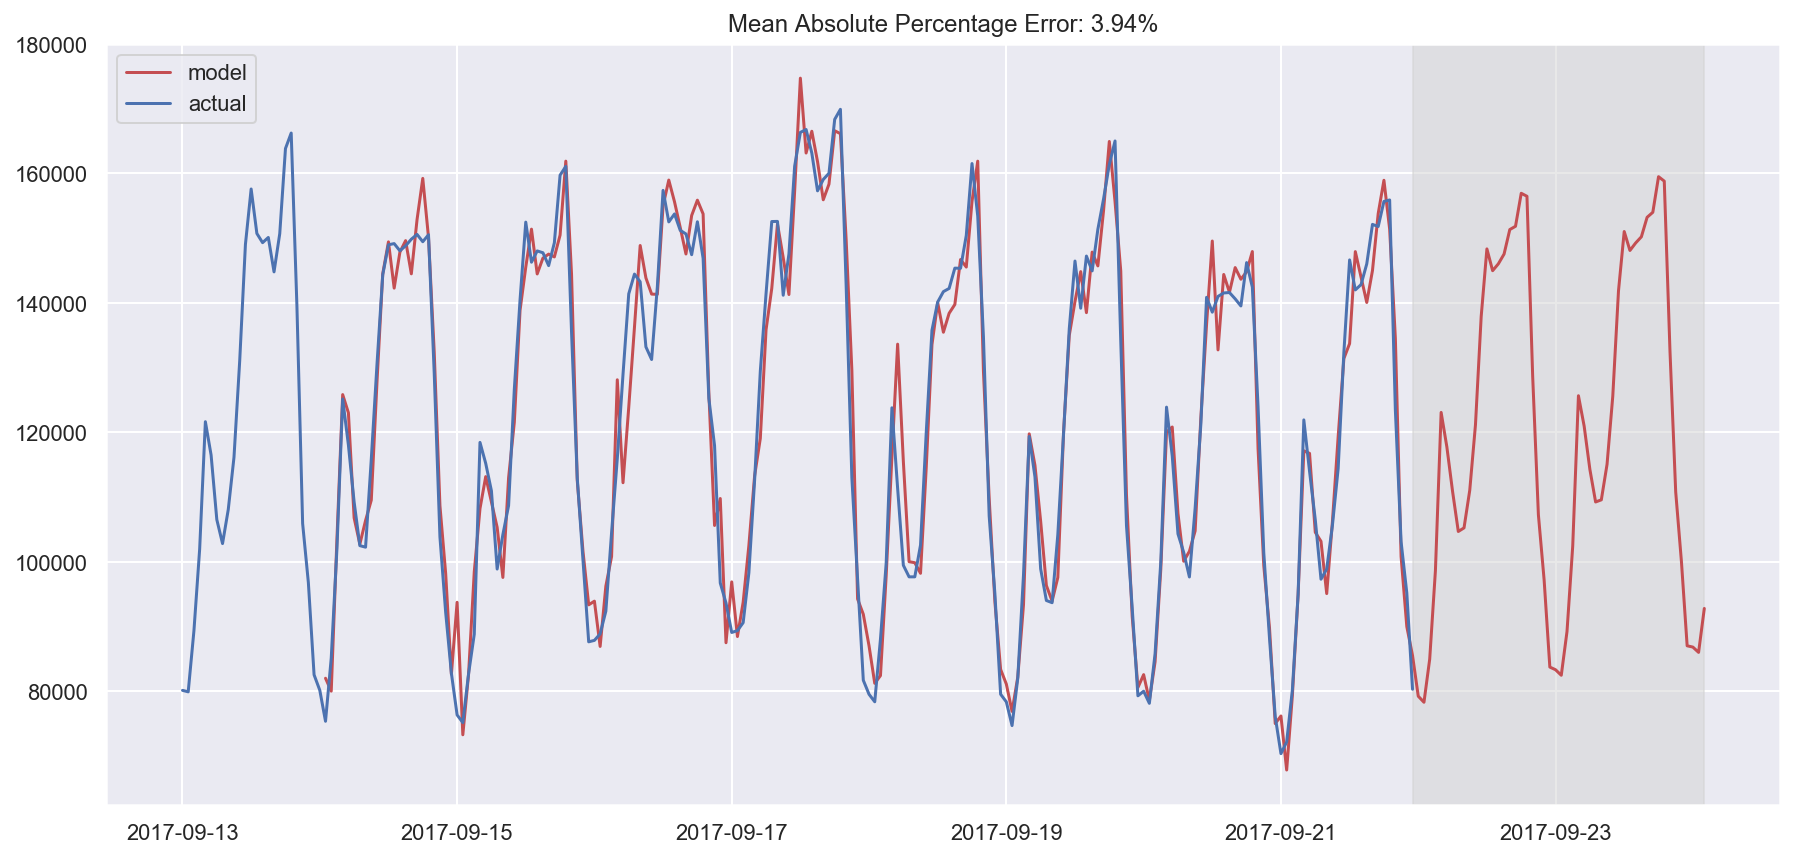

In [49]:
plotSARIMA(ads, best_model, 50)

In the end, we got very adequate predictions. Our model was wrong by 4.01% on average, which is very, very good.

## Box-Jenkins Method for Time Series Forecasting

The approach starts with the assumption that the process that generated the time series can be approximated using an ARIMA model if it is non-stationary.

1. Identification. Use the data and all related information to help select a sub-class of model that may best summarize the data.
2. Estimation. Use the data to train the parameters of the model (i.e. the coefficients p, q, d, P, D, Q).
3. Diagnostic Checking. Evaluate the fitted model in the context of the available data and check for areas where the model may be improved.

It is an iterative process, so that as new information is gained during diagnostics, you can circle back to step 1 and incorporate that into new model classes.

Sources and Helpful Reading:
- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
- https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3